Import pandas to read csv file

In [1]:
# conda activate iWM
import pandas as pd

In [2]:
ds = pd.read_csv('subset_ceramics_v21032023.csv')

# Preprocess Data-set

Remove columns that are not of interest to the model 

In [3]:
ds_preprocessed = ds.drop(columns=['find_number', 'material_category', 'start_date',
       'end_date', 'level_1_of_the_functional_classification',
       'ceramics_rim_eve_estimated_vessel_equivalent',
       'ceramics_base_eve_estimated_vessel_equivalent',
       'ceramics_decoration_technique',
       'ceramics_image_type', 'ceramics_mark'])

Remove rows where values are NaNs

In [4]:
ds_preprocessed.isna().sum()

material                                         0
level_2_of_the_functional_classification         0
ceramics_reconstructed_object_diameter_in_mm     0
ceramics_reconstructed_object_height_in_mm       0
ceramics_surface_treatment                      52
dtype: int64

In [5]:
ds_preprocessed = ds_preprocessed.dropna()
ds_preprocessed.isna().sum()

material                                        0
level_2_of_the_functional_classification        0
ceramics_reconstructed_object_diameter_in_mm    0
ceramics_reconstructed_object_height_in_mm      0
ceramics_surface_treatment                      0
dtype: int64

Reduce data-set to a binary classification problem with only 'Consumption: drinking' and 'Food consumption: plate, dish, bowl' as categories.

In [6]:
ds_preprocessed = ds_preprocessed.query("level_2_of_the_functional_classification == ['Consumption: drinking', 'Food consumption: plate, dish, bowl']")  
ds_preprocessed['level_2_of_the_functional_classification'] = ds_preprocessed['level_2_of_the_functional_classification'].astype('category')
ds_preprocessed['level_2_of_the_functional_classification']

0       Food consumption: plate, dish, bowl
1       Food consumption: plate, dish, bowl
2                     Consumption: drinking
3                     Consumption: drinking
4                     Consumption: drinking
                       ...                 
3404    Food consumption: plate, dish, bowl
3405    Food consumption: plate, dish, bowl
3406    Food consumption: plate, dish, bowl
3407    Food consumption: plate, dish, bowl
3409    Food consumption: plate, dish, bowl
Name: level_2_of_the_functional_classification, Length: 2972, dtype: category
Categories (2, object): ['Consumption: drinking', 'Food consumption: plate, dish, bowl']

Create target one-hot vector

In [7]:
#Create target output
target = pd.get_dummies(ds_preprocessed['level_2_of_the_functional_classification'])
target.sum()

Consumption: drinking                   841
Food consumption: plate, dish, bowl    2131
dtype: int64

Convert 'material' and 'ceramics_surface_treatment' in to integer values for use as input to the machine learning model and extract the features.

In [8]:
ds_preprocessed['material_categorized'] = ds_preprocessed['material'].astype('category').cat.codes + 1
ds_preprocessed['treatment_categorized'] = ds_preprocessed['ceramics_surface_treatment'].astype('category').cat.codes + 1

In [9]:
ds_features = ds_preprocessed.drop(columns=['level_2_of_the_functional_classification', 'material', 'ceramics_surface_treatment'])
ds_features

,ceramics_reconstructed_object_diameter_in_mm,ceramics_reconstructed_object_height_in_mm,material_categorized,treatment_categorized
0,270,60,32,9
1,260,38,29,5
2,100,25,9,8
3,120,150,10,19
4,110,40,15,25
...,...,...,...,...
3404,140,20,19,1
3405,120,25,32,9
3406,260,50,28,6
3407,240,28,3,25


Split data-set into train and test data-sets

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(ds_features, target,test_size=0.2, random_state=0, shuffle=True, stratify=target)

In [11]:
y_train.sum()

Consumption: drinking                   673
Food consumption: plate, dish, bowl    1704
dtype: int64

# Create NN model for classification

In [12]:
from tensorflow import keras
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(2)

In [13]:
inputs = keras.Input(shape=X_train.shape[1])

In [14]:
hidden_layer = keras.layers.Dense(10, activation="relu")(inputs)

In [15]:
output_layer = keras.layers.Dense(2, activation="softmax")(hidden_layer)

In [16]:
model = keras.Model(inputs=inputs, outputs=output_layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 72 (288.00 Byte)
Trainable params: 72 (288.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Compile and run the model

In [17]:
model.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy())

In [18]:
history = model.fit(X_train, y_train, epochs=100)

Epoch 1/100

75/75 [==============================] - 1s 1ms/step - loss: 8.3130
Epoch 2/100
75/75 [==============================] - 0s 968us/step - loss: 1.8140
Epoch 3/100
75/75 [==============================] - 0s 981us/step - loss: 0.4693
Epoch 4/100
75/75 [==============================] - 0s 973us/step - loss: 0.4145
Epoch 5/100
75/75 [==============================] - 0s 967us/step - loss: 0.3990
Epoch 6/100
75/75 [==============================] - 0s 998us/step - loss: 0.3732
Epoch 7/100
75/75 [==============================] - 0s 982us/step - loss: 0.3369
Epoch 8/100
75/75 [==============================] - 0s 987us/step - loss: 0.3215
Epoch 9/100
75/75 [==============================] - 0s 1ms/step - loss: 0.3099
Epoch 10/100
75/75 [==============================] - 0s 1ms/step - loss: 0.3073
Epoch 11/100
75/75 [==============================] - 0s 1ms/step - loss: 0.2967
Epoch 12/100
75/75 [==============================] - 0s 965us/step - loss: 0.2910
Epoch 13/100
75/75 [

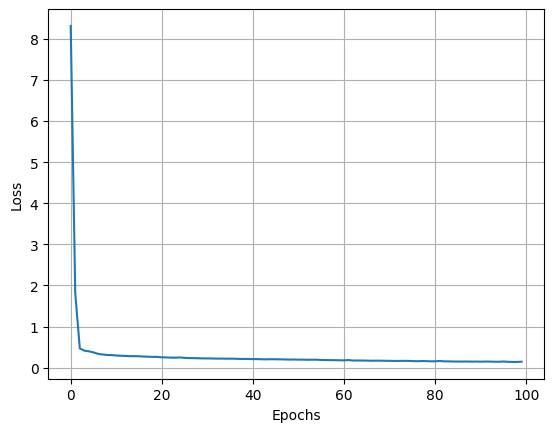

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=history.epoch, y=history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()  #just add this
plt.show()

# Predict and diagnose model results

In [27]:
y_pred = model.predict(X_test)
prediction = pd.DataFrame(y_pred, columns=target.columns)
prediction

19/19 [==============================] - 0s 1ms/step


,Consumption: drinking,"Food consumption: plate, dish, bowl"
0,3.196223e-12,1.000000
1,8.497015e-01,0.150299
2,1.132027e-12,1.000000
3,7.746588e-01,0.225341
4,2.671231e-02,0.973288
...,...,...
590,3.122591e-01,0.687741
591,2.246366e-01,0.775363
592,6.589257e-01,0.341074
593,1.415237e-02,0.985848


In [28]:
predicted_classification = prediction.idxmax(axis="columns")
predicted_classification

0      Food consumption: plate, dish, bowl
1                    Consumption: drinking
2      Food consumption: plate, dish, bowl
3                    Consumption: drinking
4      Food consumption: plate, dish, bowl
                      ...                 
590    Food consumption: plate, dish, bowl
591    Food consumption: plate, dish, bowl
592                  Consumption: drinking
593    Food consumption: plate, dish, bowl
594                  Consumption: drinking
Length: 595, dtype: category
Categories (2, object): ['Consumption: drinking', 'Food consumption: plate, dish, bowl']

Create confusion matrix to visually inspect results

In [29]:
from sklearn.metrics import confusion_matrix

true_classification = y_test.idxmax(axis="columns")

matrix = confusion_matrix(true_classification, predicted_classification)
print(matrix)

[[160   8]
 [ 19 408]]


In [30]:
# Convert to a pandas dataframe
confusion_df = pd.DataFrame(matrix, index=y_test.columns.values, columns=y_test.columns.values)

# Set the names of the x and y axis, this helps with the readability of the heatmap.
confusion_df.index.name = 'True Label'
confusion_df.columns.name = 'Predicted Label'

<Axes: xlabel='Predicted Label', ylabel='True Label'>

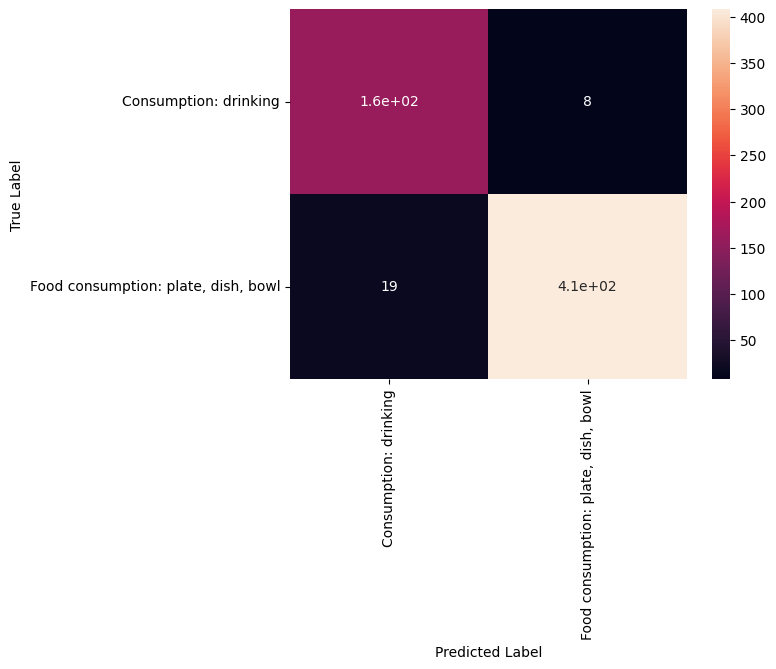

In [31]:
sns.heatmap(confusion_df, annot=True)

In [32]:
model.save('my_csvclass_model.keras')

In [33]:
pretrained_model = keras.models.load_model('my_csvclass_model.keras')
y_pretrained_pred = pretrained_model.predict(X_test)
pretrained_prediction = pd.DataFrame(y_pretrained_pred, columns=target.columns.values)

# idxmax will select the column for each row with the highest value
pretrained_predicted_class = pretrained_prediction.idxmax(axis="columns")
print(pretrained_predicted_class)

19/19 [==============================] - 0s 1ms/step
0      Food consumption: plate, dish, bowl
1                    Consumption: drinking
2      Food consumption: plate, dish, bowl
3                    Consumption: drinking
4      Food consumption: plate, dish, bowl
                      ...                 
590    Food consumption: plate, dish, bowl
591    Food consumption: plate, dish, bowl
592                  Consumption: drinking
593    Food consumption: plate, dish, bowl
594                  Consumption: drinking
Length: 595, dtype: category
Categories (2, object): ['Consumption: drinking', 'Food consumption: plate, dish, bowl']
